In [1]:
#Files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import glob

#DATA
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split

#CNN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Convolution2D,MaxPooling2D,Flatten,Dense
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy

#VIS
from keras.utils.vis_utils import plot_model

Using TensorFlow backend.


In [2]:
def _prepareData(path): 
    '''
    parameters: path(STR) of the directory and flag(INT) to know if we prepare data of training or testing
    return: (LIST) of images of the dataset and the (LIST) of labels
    
    For training:
    -Read images of every directory and extract all images
    -Resize to (128,128,3)
    -Read the directory name and asign as a class
    '''
    imgsList = []
    labels = []
    for directory in sorted(glob.glob(os.path.join(path, '*')), key = lambda k: k.split("/")[-1]):
            for imgs in glob.glob(os.path.join(directory,'*.jpg')):
                img_cv = cv2.imread(imgs)
                img_cv_r = cv2.resize(img_cv,(128,128))
                imgsList.append(img_cv_r)
                labels.append(int(directory.split("/")[-1].replace('c','')))
    

    X_Train, X_Test, Y_Train, Y_Test =  train_test_split(imgsList,labels, test_size = 0.2)
    Y_Train = tf.keras.utils.to_categorical(Y_Train, num_classes=10)
    Y_Test = tf.keras.utils.to_categorical(Y_Test, num_classes=10)

    return np.array(X_Train), np.array(X_Test), Y_Train, Y_Test

In [3]:
#Paths
pathTrain_Images = "/Users/bxia/Desktop/scu/DeepLearning_Fall2020/project/imgs/train"
pathPropagate_Images =  "/Users/bxia/Desktop/scu/DeepLearning_Fall2020/project/imgs/test"

#List of Images for Train and Test
X_Train, X_Test, Y_Train, Y_Test = _prepareData(pathTrain_Images)

print("Size X_Train: {}, Size Y_Train: {}".format(len(X_Train),len(Y_Train)))
print("Size X_Test: {}, Size Y_Test: {}".format(len(X_Test),len(Y_Test)))

Size X_Train: 17939, Size Y_Train: 17939
Size X_Test: 4485, Size Y_Test: 4485


## Check Data Intergrity

### Classes: 
c0: safe driving <br> c1: texting - right <br>c2: talking on the phone - right <br> c3: texting - left <br> c4: talking on the phone - left <br> c5: operating the radio <br>c6: drinking <br> c7: reaching behind <br>c8: hair and makeup <br>c9: talking to passenger

17939
(128, 128, 3)


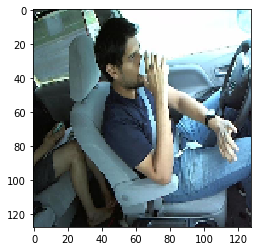

Class: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [4]:
print(len(X_Train))
print(X_Train[202].shape)
im = X_Train[202]
RGB_im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(RGB_im)
plt.show()
print("Class: {}".format(Y_Train[202]))

## Check Data Distribution

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text xticklabel objects>)

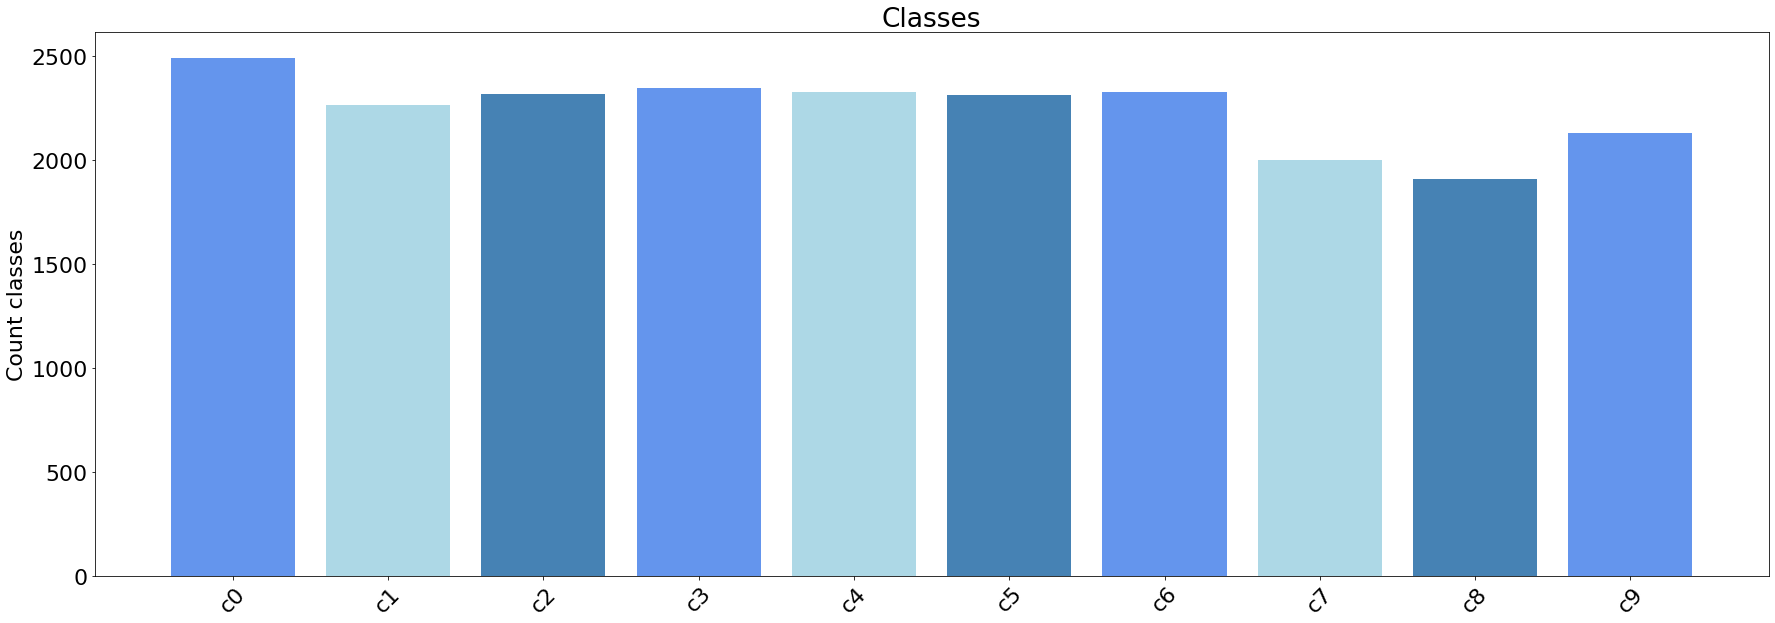

In [6]:
data_file = pd.read_csv("/Users/bxia/Desktop/scu/DeepLearning_Fall2020/project/driver_imgs_list.csv")
data_classes = data_file.loc[:,['classname','img']].groupby(by='classname').count().reset_index()

data_x = list(pd.unique(data_file['classname']))
data_y =list(data_classes['img'])

# Parámetros de ploteo (Se va a generar un plot diferente para cada Clase)
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(30,10))
plt.bar(data_x, data_y, color=['cornflowerblue', 'lightblue', 'steelblue'])  
plt.ylabel('Count classes')
plt.title('Classes')
plt.xticks(rotation=45)

## Create Architecture

In [7]:
model = keras.models.Sequential()

model.add(keras.layers.InputLayer(
    input_shape=(128, 128, 3)
))

model.add(
    keras.layers.Conv2D(
        filters=32,
        kernel_size=(5,5),
        strides = (1,1),
        padding='same',
        activation='relu',
        name='Conv_1'))

model.add(
    keras.layers.MaxPool2D(
        pool_size = (2,2),
        name = 'Pool_1'))#Image_size: 32*64*64(32 filters,image_size 64*64)

model.add(
    keras.layers.Conv2D(
        filters = 64,
        kernel_size = (5,5),
        strides = (1,1),
        padding = 'same',
        activation = 'relu',
        name = 'Conv_2'))

model.add(
    keras.layers.MaxPool2D(
        pool_size = (2,2),
        name = 'Pool_2'))#Image_size: 64*32*32(64 filters,image_size 32*32)

model.add(
    keras.layers.Conv2D(
        filters = 128,
        kernel_size = (5,5),
        strides = (1,1),
        padding = 'same',
        activation = 'relu',
        name = 'Conv_3'))

model.add(
    keras.layers.MaxPool2D(
        pool_size = (2,2),
        name = 'Pool_3'))#Image_size: 128*16*16(128 filters,image_size 16*16)

model.add(
    keras.layers.Conv2D(
        filters = 256,
        kernel_size = (5,5),
        strides = (1,1),
        padding = 'same',
        activation = 'relu',
        name = 'Conv_4'))

model.add(
    keras.layers.MaxPool2D(
        pool_size = (2,2),
        name = 'Pool_4'))#Image_size: 256*8*8(256 filters,image_size 8*8)

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(units=1024, activation='relu',name = 'fc_1'))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=512, activation='relu',name = 'fc_2'))
model.add(keras.layers.Dense(units=10,activation='softmax',name = 'fc_3'))
model.save('/tmp/model')
#model.compute_output_shape(input_shape=(256,8,8,1))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /tmp/model/assets


In [8]:
tf.random.set_seed(1)
#model.build(input_shape=(None,128,128,3))
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.CategoricalCrossentropy(from_logits = False), metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_1 (Conv2D)              (None, 128, 128, 32)      2432      
_________________________________________________________________
Pool_1 (MaxPooling2D)        (None, 64, 64, 32)        0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 64, 64, 64)        51264     
_________________________________________________________________
Pool_2 (MaxPooling2D)        (None, 32, 32, 64)        0         
_________________________________________________________________
Conv_3 (Conv2D)              (None, 32, 32, 128)       204928    
_________________________________________________________________
Pool_3 (MaxPooling2D)        (None, 16, 16, 128)       0         
_________________________________________________________________
Conv_4 (Conv2D)              (None, 16, 16, 256)       8

## Train Model

In [9]:
history = model.fit(x = X_Train, y=Y_Train,epochs = 10, batch_size = 500, verbose = 1,validation_split=0.2)

Train on 14351 samples, validate on 3588 samples
Epoch 1/10
14351/14351 [==============================] - 500s 35ms/sample - loss: 11.7081 - accuracy: 0.1732 - val_loss: 1.8711 - val_accuracy: 0.3406
Epoch 2/10
14351/14351 [==============================] - 500s 35ms/sample - loss: 1.4411 - accuracy: 0.4897 - val_loss: 0.8370 - val_accuracy: 0.7305
Epoch 3/10
14351/14351 [==============================] - 530s 37ms/sample - loss: 0.5773 - accuracy: 0.8152 - val_loss: 0.3255 - val_accuracy: 0.9072
Epoch 4/10
14351/14351 [==============================] - 487s 34ms/sample - loss: 0.2415 - accuracy: 0.9270 - val_loss: 0.1750 - val_accuracy: 0.9548
Epoch 5/10
14351/14351 [==============================] - 467s 33ms/sample - loss: 0.1436 - accuracy: 0.9577 - val_loss: 0.1140 - val_accuracy: 0.9702
Epoch 6/10
14351/14351 [==============================] - 1869s 130ms/sample - loss: 0.0812 - accuracy: 0.9756 - val_loss: 0.0942 - val_accuracy: 0.9746
Epoch 7/10
14351/14351 [==================

## Evaluate Model with Test Data

In [10]:
test_loss, test_acc = model.evaluate(X_Test, Y_Test, verbose = 1)

4485/4485 [==============================] - 37s 8ms/sample - loss: 0.0702 - accuracy: 0.9835


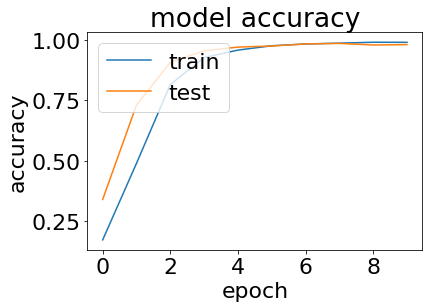

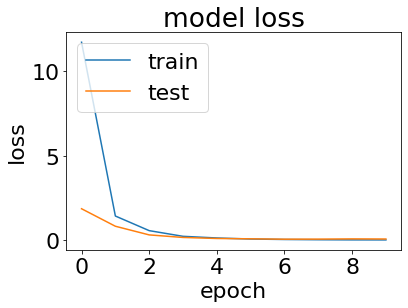

In [11]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
#plt.ylim([0.9,1])
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.ylim([0,.4])
plt.legend(['train','test'], loc='upper left')
plt.show()

### Save Weights

In [12]:
model_json = model.to_json()
model.save_weights('Train_weights_1.h5',overwrite = True)

In [13]:
model.load_weights('Train_weights_1.h5')

## Show Architecture Distribution

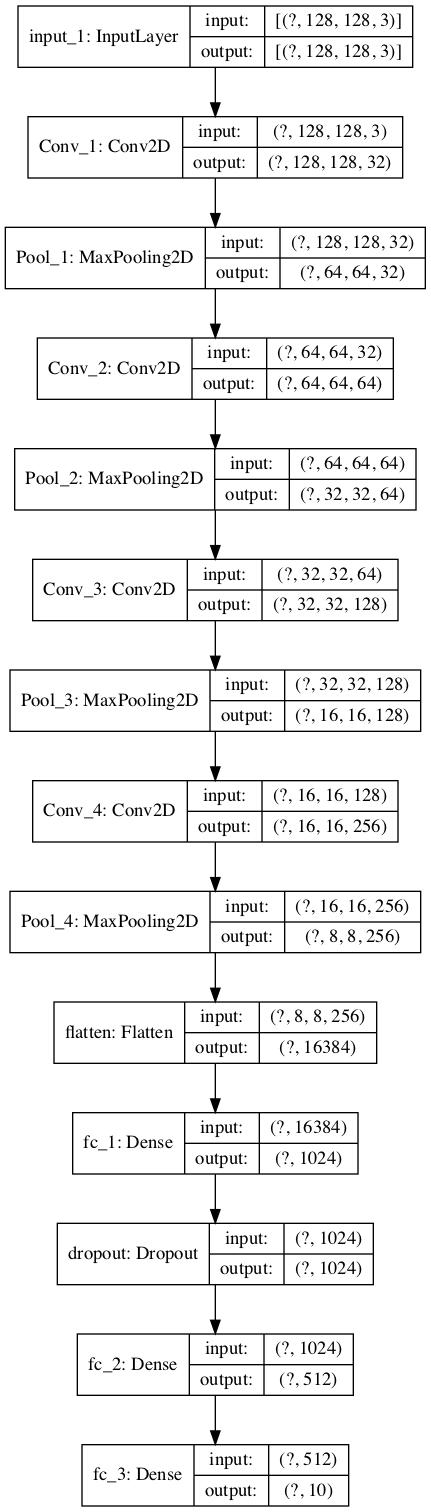

In [14]:
keras.utils.plot_model(model,"model.png",show_shapes = True)

## Predict Test Data and Create Submission File

In [15]:
df = pd.DataFrame({'img':[],'c0':[], 'c1':[],'c2':[], 'c3':[], 'c4':[],'c5':[], 'c6':[], 'c7':[], 'c8':[], 'c9':[]})
def _submission(pathPropagate_Images,df):
    for imgs in glob.glob(os.path.join(pathPropagate_Images,'*.jpg')):
        img_cv = cv2.imread(imgs)
        img_cv_r = cv2.resize(img_cv,(128,128))
        img_cv_predict = np.reshape(img_cv_r,[1,128,128,3])
        arr_predict = model.predict(img_cv_predict,batch_size = 1)
        #print(imgs.split('/')[-1])
        df = df.append(
            {
                'img':imgs.split('/')[-1],
                'c0':round(arr_predict[0][0],2), 
                'c1':round(arr_predict[0][1],2),
                'c2':round(arr_predict[0][2],2),
                'c3':round(arr_predict[0][3],2),
                'c4':round(arr_predict[0][4],2),
                'c5':round(arr_predict[0][5],2),
                'c6':round(arr_predict[0][6],2),
                'c7':round(arr_predict[0][7],2),
                'c8':round(arr_predict[0][8],2),
                'c9':round(arr_predict[0][9],2)
            },
            ignore_index=True
        )
    return df

In [17]:
img_cv = cv2.imread("/Users/bxia/Desktop/scu/DeepLearning_Fall2020/project/imgs/test/img_41.jpg")
img_cv_r = cv2.resize(img_cv,(128,128))
img_cv_predict = np.reshape(img_cv_r,[1,128,128,3])
arr_predict = model.predict(img_cv_predict,batch_size = 1)

print(arr_predict)
print(round(arr_predict[0][9],2))


[[9.9429083e-01 4.0323937e-07 5.5156916e-04 2.0409276e-05 2.0910001e-04
  2.7462529e-05 1.8360561e-07 9.4188734e-05 3.3875867e-03 1.4183250e-03]]
0.0


In [18]:
pathPropagate_Images = "/Users/bxia/Desktop/scu/DeepLearning_Fall2020/project/imgs/test"
df = _submission(pathPropagate_Images,df)

In [19]:
print(df.shape)
df.head(50)

(79726, 11)


img    c0    c1    c2    c3    c4    c5    c6    c7    c8    c9
0   img_60161.jpg  0.00  0.00  0.00  0.00  0.00  1.00  0.00  0.00  0.00  0.00
1   img_94786.jpg  0.00  0.00  0.00  0.00  0.00  0.00  0.95  0.00  0.05  0.00
2   img_85853.jpg  0.00  0.35  0.00  0.00  0.01  0.00  0.20  0.15  0.00  0.29
3   img_36327.jpg  0.00  0.00  0.00  0.00  0.72  0.00  0.12  0.16  0.00  0.00
4   img_39014.jpg  0.96  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.04
5   img_84595.jpg  0.01  0.00  0.04  0.00  0.68  0.01  0.03  0.00  0.00  0.22
6   img_57915.jpg  0.00  0.00  0.02  0.17  0.00  0.75  0.00  0.00  0.00  0.07
7   img_37039.jpg  0.00  0.00  0.00  0.00  0.00  1.00  0.00  0.00  0.00  0.00
8   img_11940.jpg  0.00  0.00  0.00  0.00  0.00  0.00  1.00  0.00  0.00  0.00
9   img_20545.jpg  0.23  0.00  0.05  0.00  0.00  0.04  0.00  0.00  0.00  0.67
10  img_66510.jpg  0.00  0.00  0.00  0.00  0.00  0.00  1.00  0.00  0.00  0.00
11  img_10486.jpg  0.02  0.97  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.01
12  img_79430.jpg  0.00  0.00  0.00  1.00  0.00  0.00  0.00  0.00  0.00  0.00
13  img_48835.jpg  0.00  0.00  0.00  0.00  0.00  1.00  0.00  0.00  0.00  0.00
14  img_30756.jpg  0.00  0.00  0.00  1.00  0.00  0.00  0.00  0.00  0.00  0.00
15  img_21883.jpg  0.00  0.00  0.00  0.00  0.01  0.13  0.00  0.00  0.00  0.86
16  img_96191.jpg  0.00  0.09  0.00  0.00  0.04  0.85  0.01  0.00  0.00  0.00
17  img_24723.jpg  0.00  0.00  0.00  0.00  0.00  0.00  0.97  0.03  0.00  0.00
18  img_62776.jpg  0.00  0.00  0.00  0.00  0.00  0.00  1.00  0.00  0.00  0.00
19  img_65019.jpg  0.02  0.00  0.00  0.95  0.00  0.02  0.00  0.00  0.00  0.00
20  img_43960.jpg  0.00  0.00  0.00  0.82  0.03  0.00  0.08  0.03  0.04  0.00
21  img_86382.jpg  0.00  0.00  0.98  0.00  0.00  0.00  0.02  0.00  0.00  0.00
22  img_72565.jpg  0.00  0.88  0.02  0.00  0.00  0.00  0.00  0.00  0.10  0.00
23  img_22352.jpg  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.58  0.42
24  img_74114.jpg  0.00  0.13  0.00  0.00  0.00  0.00  0.87  0.00  0.00  0.00
25   img_5811.jpg  0.00  1.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00
26  img_14838.jpg  0.01  0.00  0.05  0.88  0.03  0.01  0.00  0.00  0.00  0.02
27  img_32141.jpg  0.00  0.00  0.00  0.00  0.00  0.00  1.00  0.00  0.00  0.00
28  img_12291.jpg  0.00  0.00  0.00  1.00  0.00  0.00  0.00  0.00  0.00  0.00
29  img_63468.jpg  0.00  0.26  0.02  0.00  0.00  0.00  0.00  0.00  0.69  0.03
30    img_329.jpg  0.00  0.00  0.00  0.00  0.00  0.00  1.00  0.00  0.00  0.00
31  img_32627.jpg  0.00  0.00  0.00  0.00  0.02  0.98  0.00  0.00  0.00  0.00
32  img_80095.jpg  0.00  0.00  0.00  0.00  0.00  0.00  1.00  0.00  0.00  0.00
33  img_22434.jpg  0.99  0.00  0.00  0.00  0.01  0.00  0.00  0.00  0.00  0.00
34  img_15298.jpg  0.00  0.00  0.00  0.00  0.00  0.00  0.00  1.00  0.00  0.00
35  img_35148.jpg  0.04  0.00  0.00  0.00  0.96  0.00  0.00  0.00  0.00  0.00
36  img_90286.jpg  0.00  0.00  0.00  0.00  0.00  0.00  1.00  0.00  0.00  0.00
37  img_55864.jpg  0.13  0.01  0.00  0.21  0.09  0.00  0.00  0.00  0.10  0.47
38  img_13831.jpg  0.00  0.00  0.00  0.00  0.00  1.00  0.00  0.00  0.00  0.00
39   img_2818.jpg  0.00  0.00  0.00  0.00  0.00  0.00  0.02  0.98  0.00  0.00
40  img_98802.jpg  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.97  0.03
41  img_72203.jpg  0.00  0.00  0.75  0.00  0.00  0.00  0.25  0.00  0.00  0.00
42  img_91198.jpg  0.00  0.00  0.00  0.00  0.00  0.00  1.00  0.00  0.00  0.00
43  img_34256.jpg  0.38  0.51  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.12
44  img_87922.jpg  0.06  0.00  0.00  0.00  0.00  0.00  0.94  0.00  0.00  0.00
45  img_24045.jpg  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  1.00  0.00
46  img_61519.jpg  0.00  0.00  0.00  0.00  0.00  1.00  0.00  0.00  0.00  0.00
47  img_79356.jpg  0.00  0.03  0.00  0.00  0.00  0.00  0.00  0.00  0.05  0.92
48  img_93957.jpg  0.07  0.00  0.00  0.00  0.04  0.00  0.89  0.00  0.00  0.00
49   img_7960.jpg  0.32  0.00  0.00  0.00  0.67  0.01  0.00  0.00  0.00  0.00

In [20]:
df.to_csv('submission_file.csv',index = False)